In [9]:
INSTANCE = 'LR1_1_DR1_3_VC1_V7a'
# INSTANCE = 'LR1_1_DR1_4_VC3_V8a'
# INSTANCE = 'LR1_1_DR1_4_VC3_V9a'
# INSTANCE = 'LR1_1_DR1_4_VC3_V11a'
# INSTANCE = 'LR1_1_DR1_4_VC3_V12a'
# INSTANCE = 'LR1_1_DR1_4_VC3_V12b'
# INSTANCE = 'LR1_2_DR1_3_VC2_V6a'
# INSTANCE = 'LR1_2_DR1_3_VC3_V8a'
# INSTANCE = 'LR2_11_DR2_22_VC3_V6a'
# INSTANCE = 'LR2_11_DR2_33_VC4_V11a'

MODEL = "MIRP_operating_speed_results_"
# MODEL = "mirpso_results_"

TP = str(45)

FILEPATH = 'solutions'+'/'+MODEL+INSTANCE+'_tp_'+TP+'.txt'

In [10]:
class Port:
    def __init__(self, capacity, inventory, rate, price, berth_limit, port_fee, max_amount, min_amount, number, isLoadingPort):
        self.capacity = capacity
        self.inventory = inventory
        self.rate = rate
        self.price = price 
        self.berth_limit = berth_limit 
        self.port_fee = port_fee
        self.max_amount = max_amount
        self.min_amount = min_amount
        self.number = number
        self.isLoadingPort = isLoadingPort
        
    def __repr__(self):
        return f'Port {self.number}'
    
    def __repr2__(self):
        return f'Port {self.number}: Capacity = {self.capacity}, Inventory = {self.inventory}, Rate = {self.rate}, Price = {self.price}, Berth Limit = {self.berth_limit}, Port Fee = {self.port_fee}, Max Amount = {self.max_amount}, Min Amount = {self.min_amount}, is Loading Port = {self.isLoadingPort}'
        
    

class Node:
    def __init__(self, port, time):
        self.port = port
        self.time = time
        self.tuple = (port.number if port else None, time)
        self.incoming_arcs = set()
        self.outgoing_arcs = set()
        self.berths = port.berth_limit if port else None
    
    def __repr__(self):
        return str(self.tuple)


class Arc:
    def __init__(self, origin_node, destination_node, distance, cost, travel_time, speed, is_waiting_arc):
        self.origin_node = origin_node
        self.destination_node = destination_node
        self.tuple = (origin_node, destination_node)
        self.distance = distance
        self.cost = cost
        self.travel_time = travel_time
        self.speed = speed
        self.is_waiting_arc = is_waiting_arc
            
    def __repr__(self):
        return f'{self.origin_node} -> {self.destination_node} --- Cost: {self.cost} --- Speed: {self.speed}'

class Vessel:
    def __init__(self, max_inventory, initial_inventory, max_operating_quantity, number):
        self.max_inventory = int(max_inventory)
        self.inventory = initial_inventory
        self.max_operating_quantity = max_operating_quantity
        self.number = number
        self.arcs = set()
        self.all_arcs_v = set()
        
    def __repr__(self):
        return f'Vessel {self.number}'

    def __repr2__(self):
        return f'Vessel {self.number}: Max Inventory = {self.max_inventory}, Inventory = {self.inventory}, Max Operating Quantity = {self.max_operating_quantity}'
        

In [11]:
import re

def create_ports_and_vessels_from_file():
    with open(FILEPATH, 'r') as file:
        lines = file.readlines()

    # Creating Port objects
    ports = []
    ports_section = False
    for line in lines:
        if "Ports:" in line:
            ports_section = True
            continue

        if ports_section:
            if line.strip() == "":
                ports_section = False
                continue
            # Extracting port data
            match = re.match(r"Port (\d+): Capacity = (\d+), Inventory = (\d+), Rate = (\d+), Price = (None|\d+), Berth Limit = (\d+), Port Fee = (\d+), Max Amount = (\d+), Min Amount = (\d+), is Loading Port = (-?\d+)", line.strip())
            if match:
                ports.append(Port(int(match.group(2)), int(match.group(3)), int(match.group(4)), 
                                  None if match.group(5) == "None" else float(match.group(5)), 
                                  int(match.group(6)), int(match.group(7)), int(match.group(8)), 
                                  int(match.group(9)), int(match.group(1)), int(match.group(10)) == 1))

    # Creating Vessel objects
    vessels = []
    vessels_section = False
    for line in lines:
        if "Vessels:" in line:
            vessels_section = True
            continue

        if vessels_section:
            if line.strip() == "":
                vessels_section = False
                continue
            # Extracting vessel data
            match = re.match(r"Vessel (\d+): Max Inventory = (\d+), Inventory = (\d+), Max Operating Quantity = (\d+)", line.strip())
            if match:
                vessels.append(Vessel(int(match.group(2)), int(match.group(3)), int(match.group(4)), int(match.group(1))))

    return ports, vessels

# Assuming the text file is saved as 'mirpso_results_19_nov_tp31.txt'
ports, vessels = create_ports_and_vessels_from_file()

# Printing the created objects for verification
print("Ports:", ports)
print("Vessels:", vessels)


Ports: [Port 1, Port 2, Port 3, Port 4]
Vessels: [Vessel 1, Vessel 2, Vessel 3, Vessel 4, Vessel 5, Vessel 6, Vessel 7]


In [12]:
def extract_time_periods():
    with open(FILEPATH, 'r') as file:
        lines = file.readlines()

    time_periods = None

    for line in lines:
        if line.startswith('Number of Time Periods'):
            time_periods = int(line.split(':')[1].strip())

    return time_periods

def create_nodes(ports, time_periods):
    nodes = []
    for port in ports:
        for time in range(1,time_periods+1):
            nodes.append(Node(port, time))
    return nodes

# Using the modified function
TIME_PERIODS = extract_time_periods()
nodes = create_nodes(ports, TIME_PERIODS)

# Add source node¨
sourcePort = Port(0,0,0,0,0,0,0,0,0,0)
source_node = Node(sourcePort, 0)
nodes.append(source_node)

# Add sink node
sinkPort = Port(0,0,0,0,0,0,0,0,len(ports)+1,0)
sink_node = Node(sinkPort, TIME_PERIODS+1)
nodes.append(sink_node)


In [13]:
def create_arcs_from_file( ports, vessels):
    with open(FILEPATH, 'r') as file:
        lines = file.readlines()

    ports_dict = {port.number: port for port in ports}
    # add SourcePort and SinkPort
    sourcePort = Port(0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
    sinkPort = Port(0, 0, 0, 0, 0, 0, 0, 0, len(ports)+1, 0)
    ports_dict[0] = sourcePort
    ports_dict[len(ports)+1] = sinkPort
    vessels_dict = {vessel.number: vessel for vessel in vessels}
    nodes_dict = {}  # Dictionary to store and reuse Node instances

    default_distance = 0
    default_cost = 0
    default_travel_time = 0
    default_speed = 0
    default_is_waiting_arc = False

    vessel_arcs = {vessel.number: set() for vessel in vessels}
    
    traveled_threshold = 0.99

    for line in lines:
        if line.startswith("x["):
            # match = re.match(r"x\[\(\((\d+), (\d+)\), \((\d+), (\d+)\)\),Vessel (\d+)\]: (\d+\.?\d*)", line.strip())
            match = re.match(r"x\[\(\((\d+), (\d+)\), \((\d+), (\d+)\)\),Vessel (\d+)\]: ([0-9.e+-]+)", line.strip())
            if match:
                origin_port_num, origin_time = int(match.group(1)), int(match.group(2))
                dest_port_num, dest_time = int(match.group(3)), int(match.group(4))
                vessel_number = int(match.group(5))
                traveled_value = float(match.group(6))
                traveled = traveled_value >= traveled_threshold
                # traveled = float(match.group(6)) == 1.0

                if traveled and origin_port_num in ports_dict and dest_port_num in ports_dict:
                    origin_node_key = (origin_port_num, origin_time)
                    dest_node_key = (dest_port_num, dest_time)

                    # Reuse or create the origin and destination nodes
                    origin_node = nodes_dict.get(origin_node_key) or Node(ports_dict[origin_port_num], origin_time)
                    nodes_dict[origin_node_key] = origin_node

                    destination_node = nodes_dict.get(dest_node_key) or Node(ports_dict[dest_port_num], dest_time)
                    nodes_dict[dest_node_key] = destination_node

                    arc = Arc(origin_node, destination_node, default_distance, default_cost, default_travel_time, default_speed, default_is_waiting_arc)
                    
                    vessel_arcs[vessel_number].add(arc)

    return vessel_arcs

In [14]:
vessel_arcs_dict = create_arcs_from_file(ports, vessels)
vessel_arcs_dict


{1: {(0, 0) -> (4, 7) --- Cost: 0 --- Speed: 0,
  (1, 17) -> (1, 18) --- Cost: 0 --- Speed: 0,
  (1, 18) -> (4, 28) --- Cost: 0 --- Speed: 0,
  (1, 38) -> (1, 39) --- Cost: 0 --- Speed: 0,
  (1, 39) -> (5, 46) --- Cost: 0 --- Speed: 0,
  (4, 28) -> (1, 38) --- Cost: 0 --- Speed: 0,
  (4, 7) -> (1, 17) --- Cost: 0 --- Speed: 0},
 2: {(0, 0) -> (1, 8) --- Cost: 0 --- Speed: 0,
  (1, 30) -> (5, 46) --- Cost: 0 --- Speed: 0,
  (1, 8) -> (1, 9) --- Cost: 0 --- Speed: 0,
  (1, 9) -> (2, 19) --- Cost: 0 --- Speed: 0,
  (2, 19) -> (2, 20) --- Cost: 0 --- Speed: 0,
  (2, 20) -> (1, 30) --- Cost: 0 --- Speed: 0},
 3: {(0, 0) -> (1, 1) --- Cost: 0 --- Speed: 0,
  (1, 1) -> (1, 2) --- Cost: 0 --- Speed: 0,
  (1, 2) -> (1, 3) --- Cost: 0 --- Speed: 0,
  (1, 28) -> (2, 38) --- Cost: 0 --- Speed: 0,
  (1, 3) -> (1, 4) --- Cost: 0 --- Speed: 0,
  (1, 4) -> (1, 5) --- Cost: 0 --- Speed: 0,
  (1, 5) -> (4, 15) --- Cost: 0 --- Speed: 0,
  (2, 38) -> (5, 46) --- Cost: 0 --- Speed: 0,
  (4, 15) -> (4, 16) 

In [22]:
def create_o_vars_dict():
    with open(FILEPATH, 'r') as file:
        lines = file.readlines()

    o_vars = {}

    for line in lines:
        if line.startswith("o["):
            # Regular expression to match the o-vars line format
            # match = re.match(r"o\[(\d+),(\d+),Vessel (\d+)\]: (\d\.?\d*)", line.strip())
            match = re.match(r"o\[(\d+),(\d+),Vessel (\d+)\]: ([0-9.e+-]+)", line.strip())
            if match:
                port_num = int(match.group(1))
                time_period = int(match.group(2))
                vessel_num = int(match.group(3))
                value = float(match.group(4))

                # Using a tuple of (port_num, time_period, vessel_num) as the key
                key = (port_num, time_period, vessel_num)
                o_vars[key] = value

    return o_vars

In [23]:
o_vars_dict = create_o_vars_dict()

In [24]:
import networkx as nx
# import matplotlib as plt
import matplotlib.pyplot as plt


def visualize_solution_for_vessel(vessel, vessel_arcs, nodes, o):
    
    ebs = 0.1
    
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes to the graph
    for node in nodes:
        G.add_node(str(node.tuple))

    # Add edges (arcs) to the graph
    for arc in vessel_arcs[vessel]:
        G.add_edge(str(arc.origin_node.tuple), str(arc.destination_node.tuple))

    # Determine nodes with incoming and outgoing arcs
    nodes_with_incoming_arcs = [node for node, degree in G.in_degree() if degree > 0]
    nodes_with_outgoing_arcs = [node for node, degree in G.out_degree() if degree > 0]

   # Create a list to hold node colors
    node_colors = []
    for node_str in G.nodes():
        port_number, time = eval(node_str)  # Extract port number and time from the node label
        o_value = o.get((port_number, time, vessel))  # Use .get() to safely access the dictionary
        if o_value and o_value > 0 + ebs:
            node_colors.append('brown')  # Color for nodes with non-zero q values
        elif node_str in nodes_with_incoming_arcs or node_str in nodes_with_outgoing_arcs:
            node_colors.append('green')  # Color for nodes with arcs
        
        else:
            node_colors.append('skyblue')  # Default color for nodes without arcs or q values


    # Resetting the y_offset and y_spacing
    y_offset = 10
    y_spacing = -30  # Increase vertical spacing for better clarity

    # Manually specify the positions for each node
    pos = {}
    for node_str in G.nodes():
        port_number, time = eval(node_str)  # Extract port number and time from the node label
        # The x-coordinate is based on time, the y-coordinate is fixed for nodes with the same port
        pos[node_str] = (time * 10, port_number * y_spacing)  # Multiplying time by 10 for better horizontal spacing

    # Drawing the graph using the adjusted positions
    plt.figure(figsize=(15, 10))
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color=node_colors, font_size=10)
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.title(f"Nodes and Arcs Graph for {vessel}")
    plt.show()

In [25]:
# Sort the arcs for each vessel by time
for i in range(1, len(vessels)+1):
    vessel_arcs_dict[i] = sorted(vessel_arcs_dict[i], key=lambda arc: arc.origin_node.time)

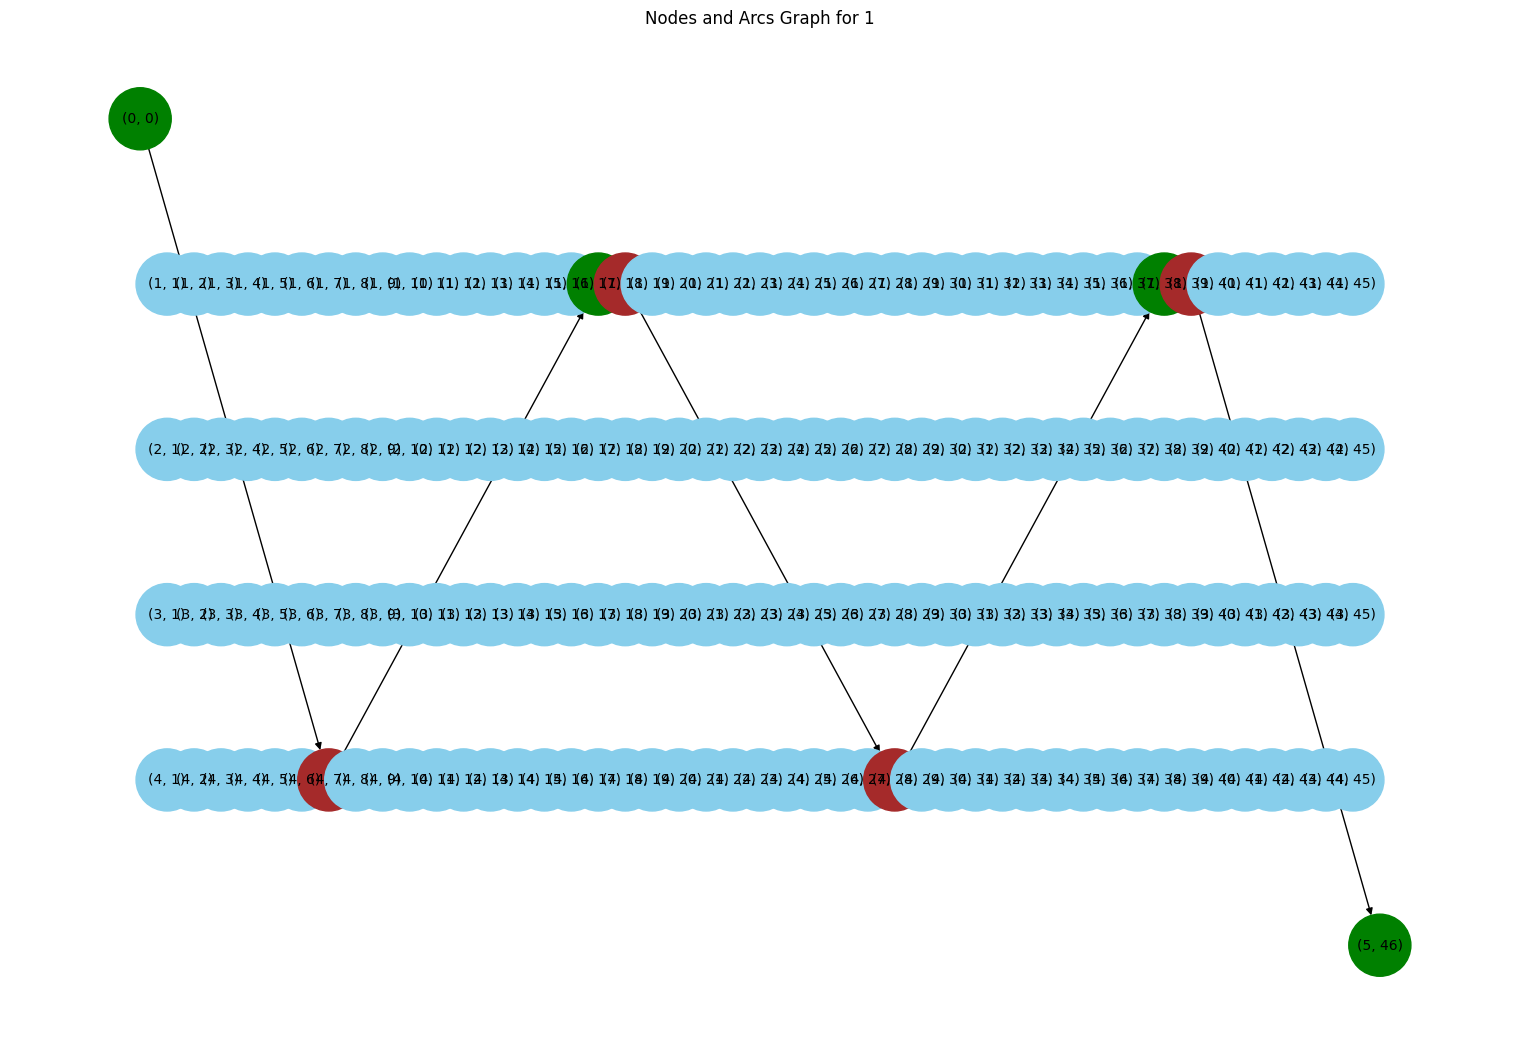

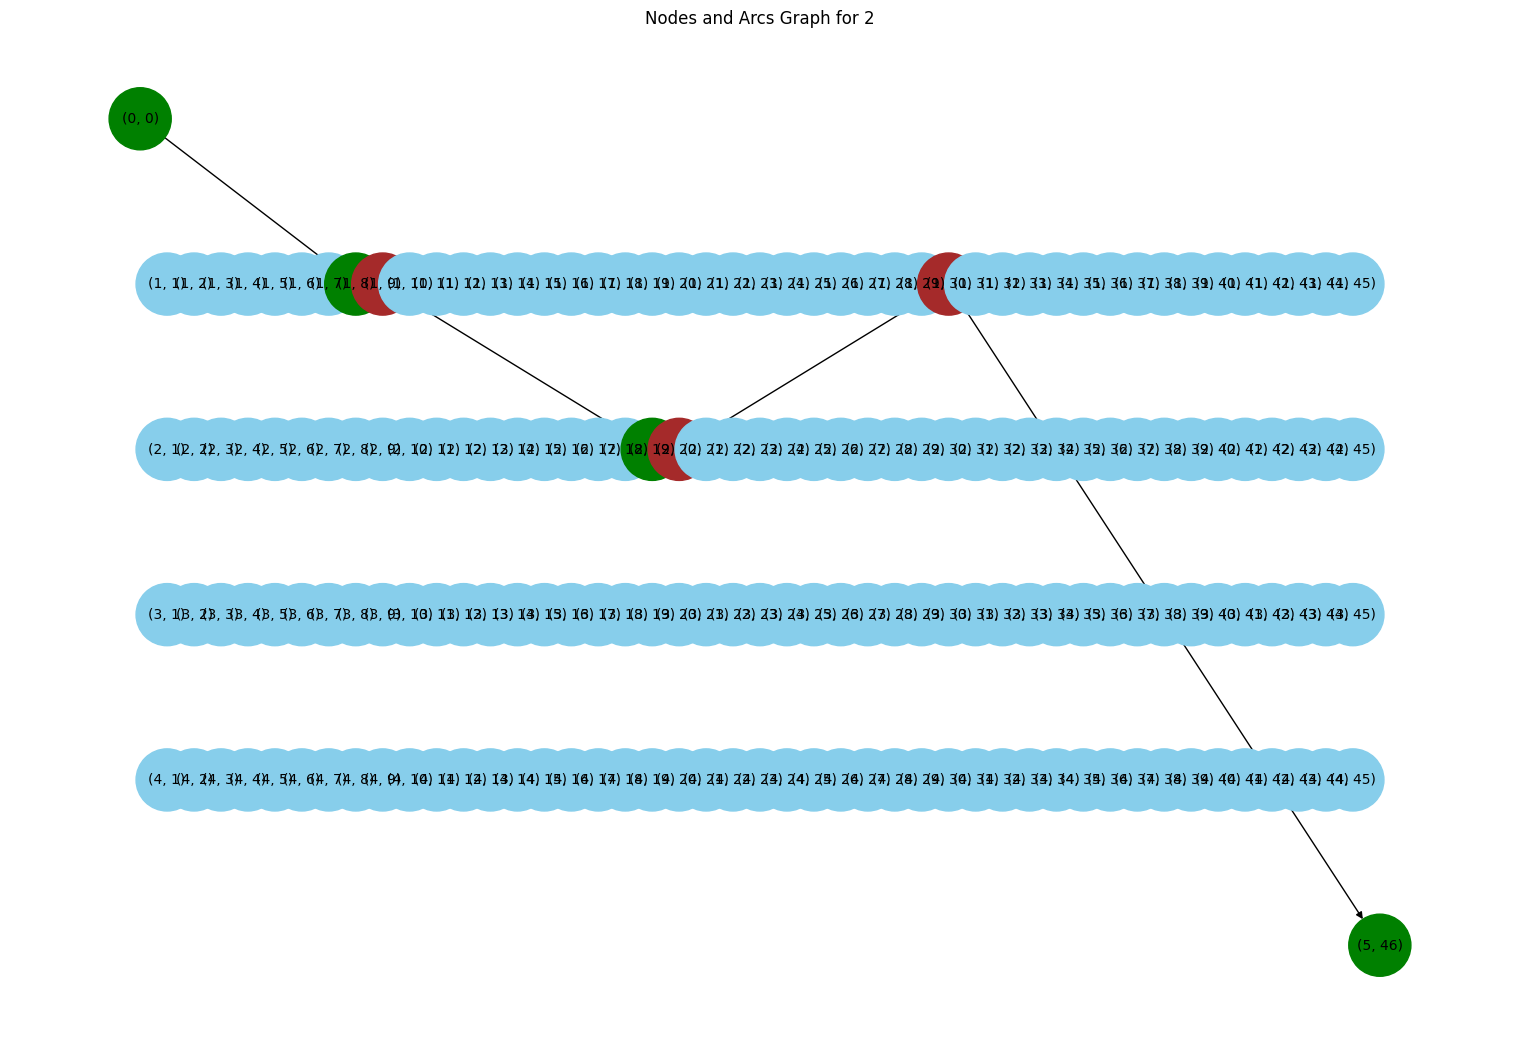

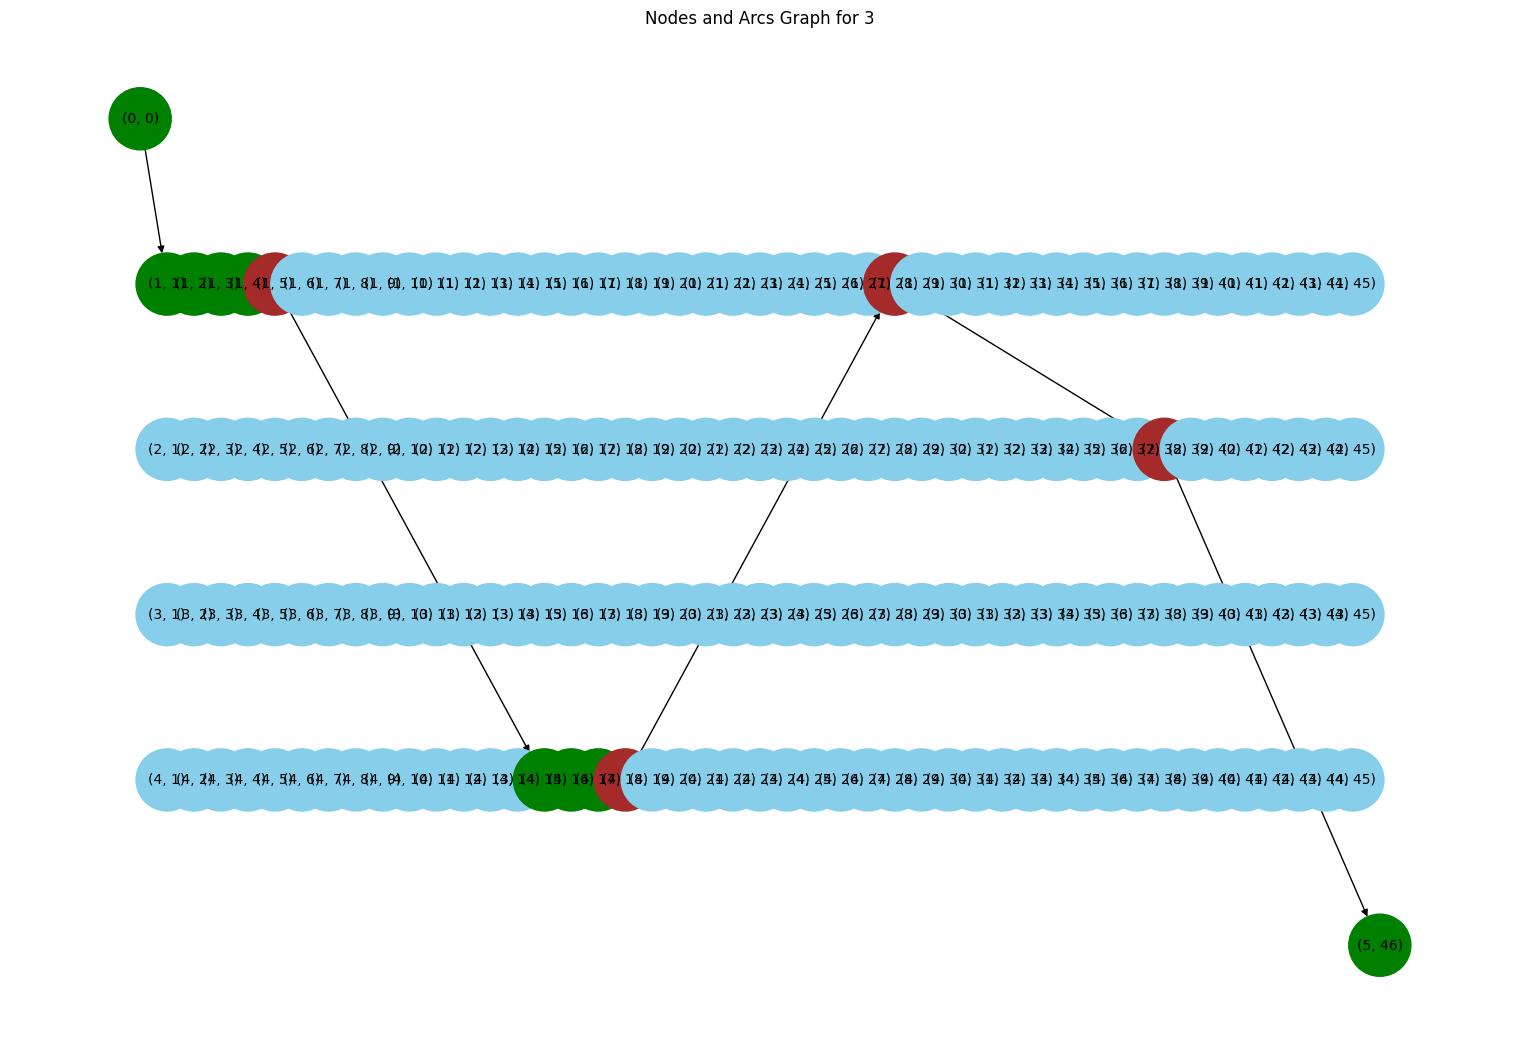

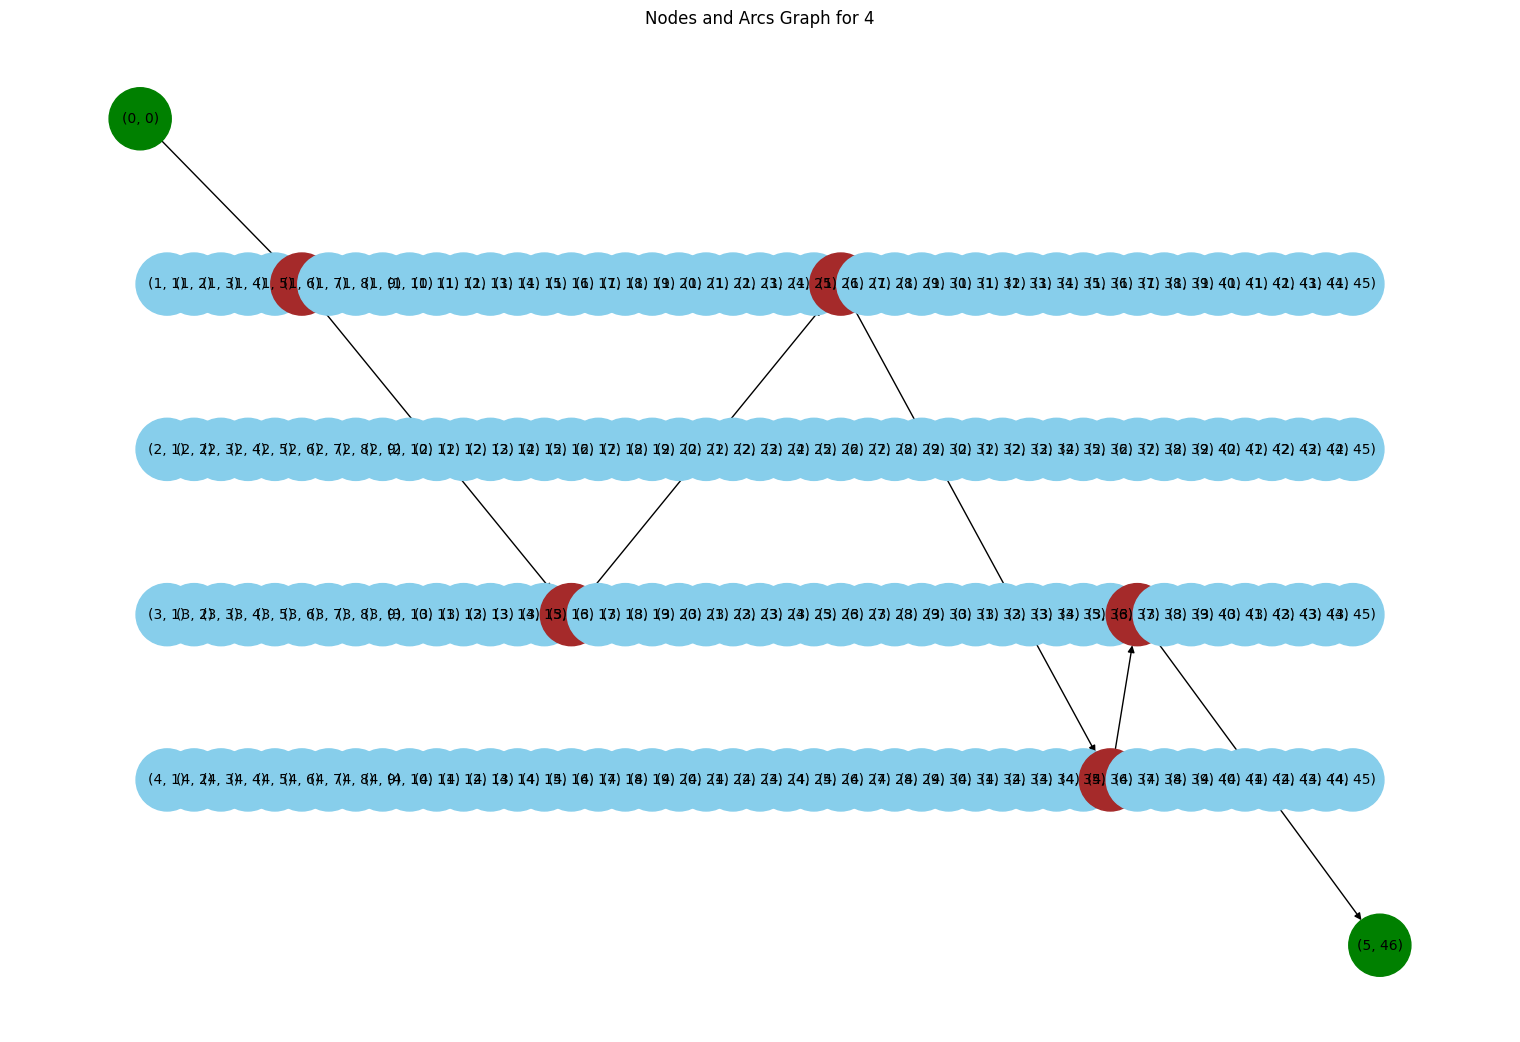

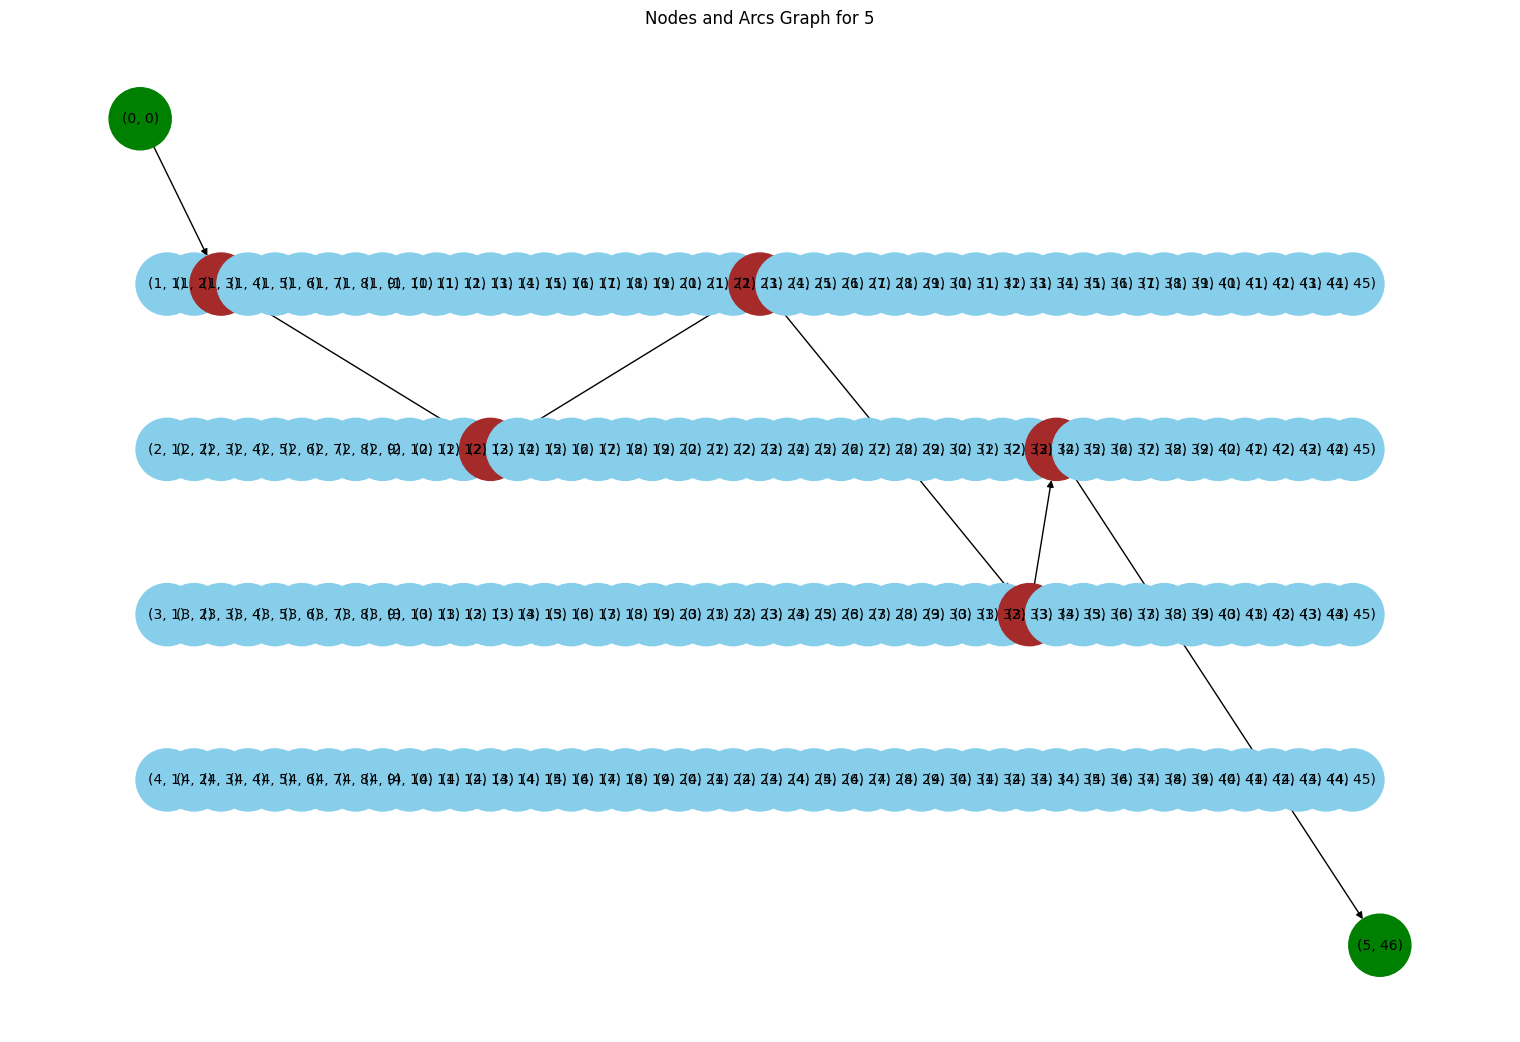

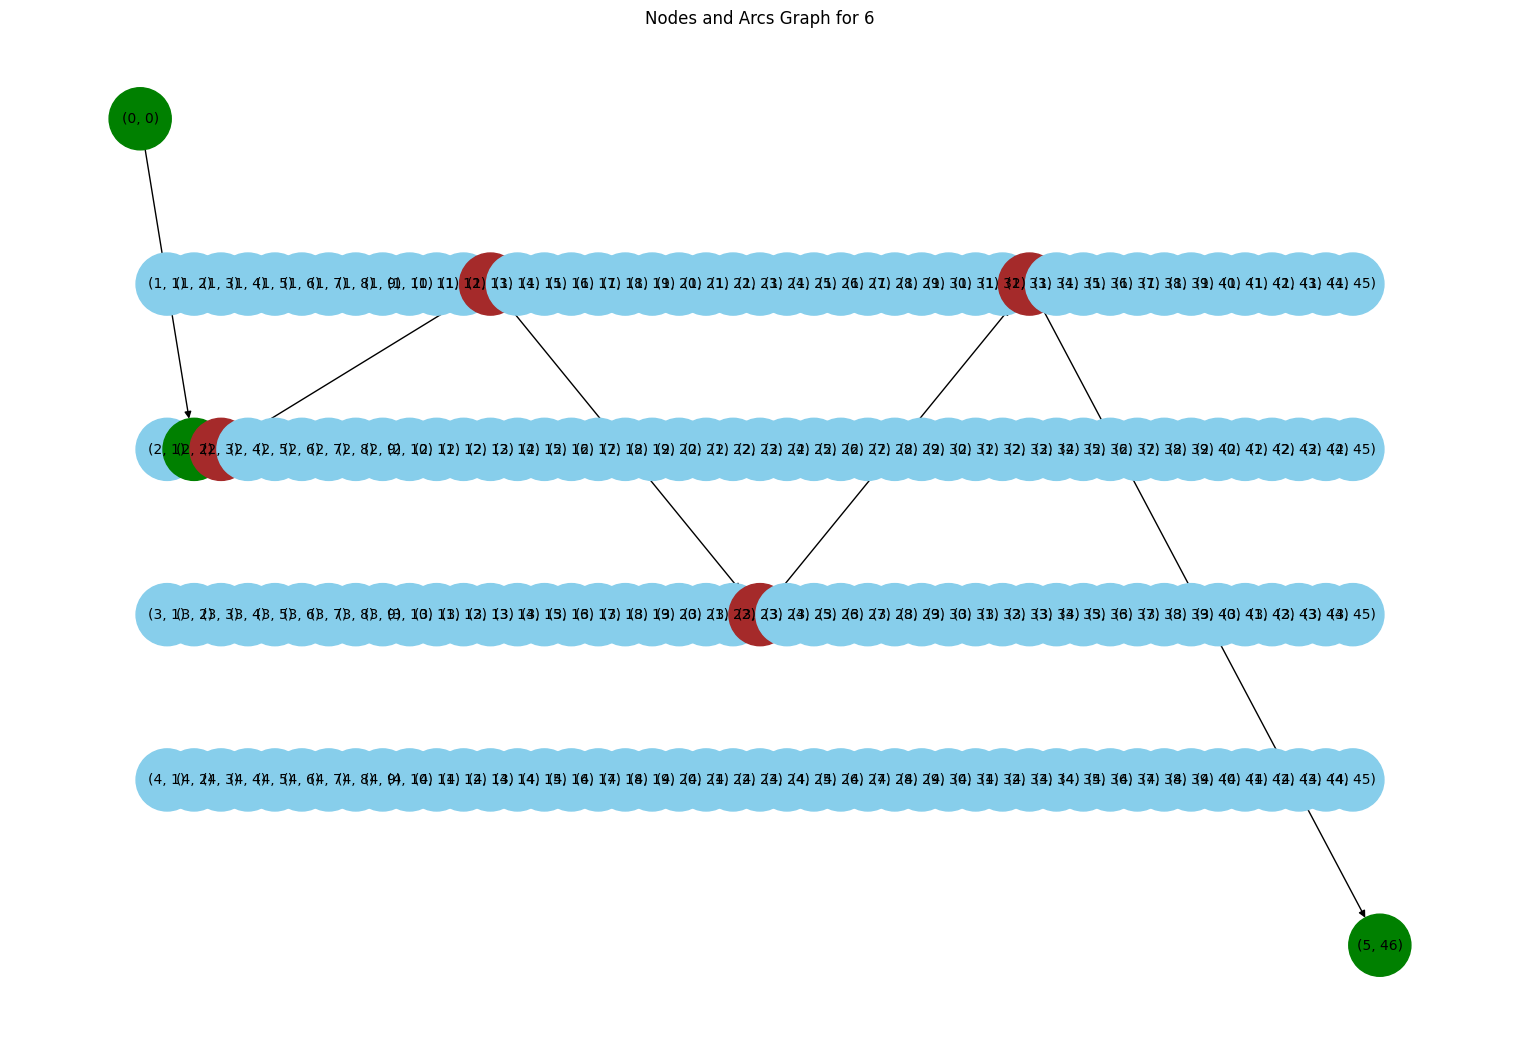

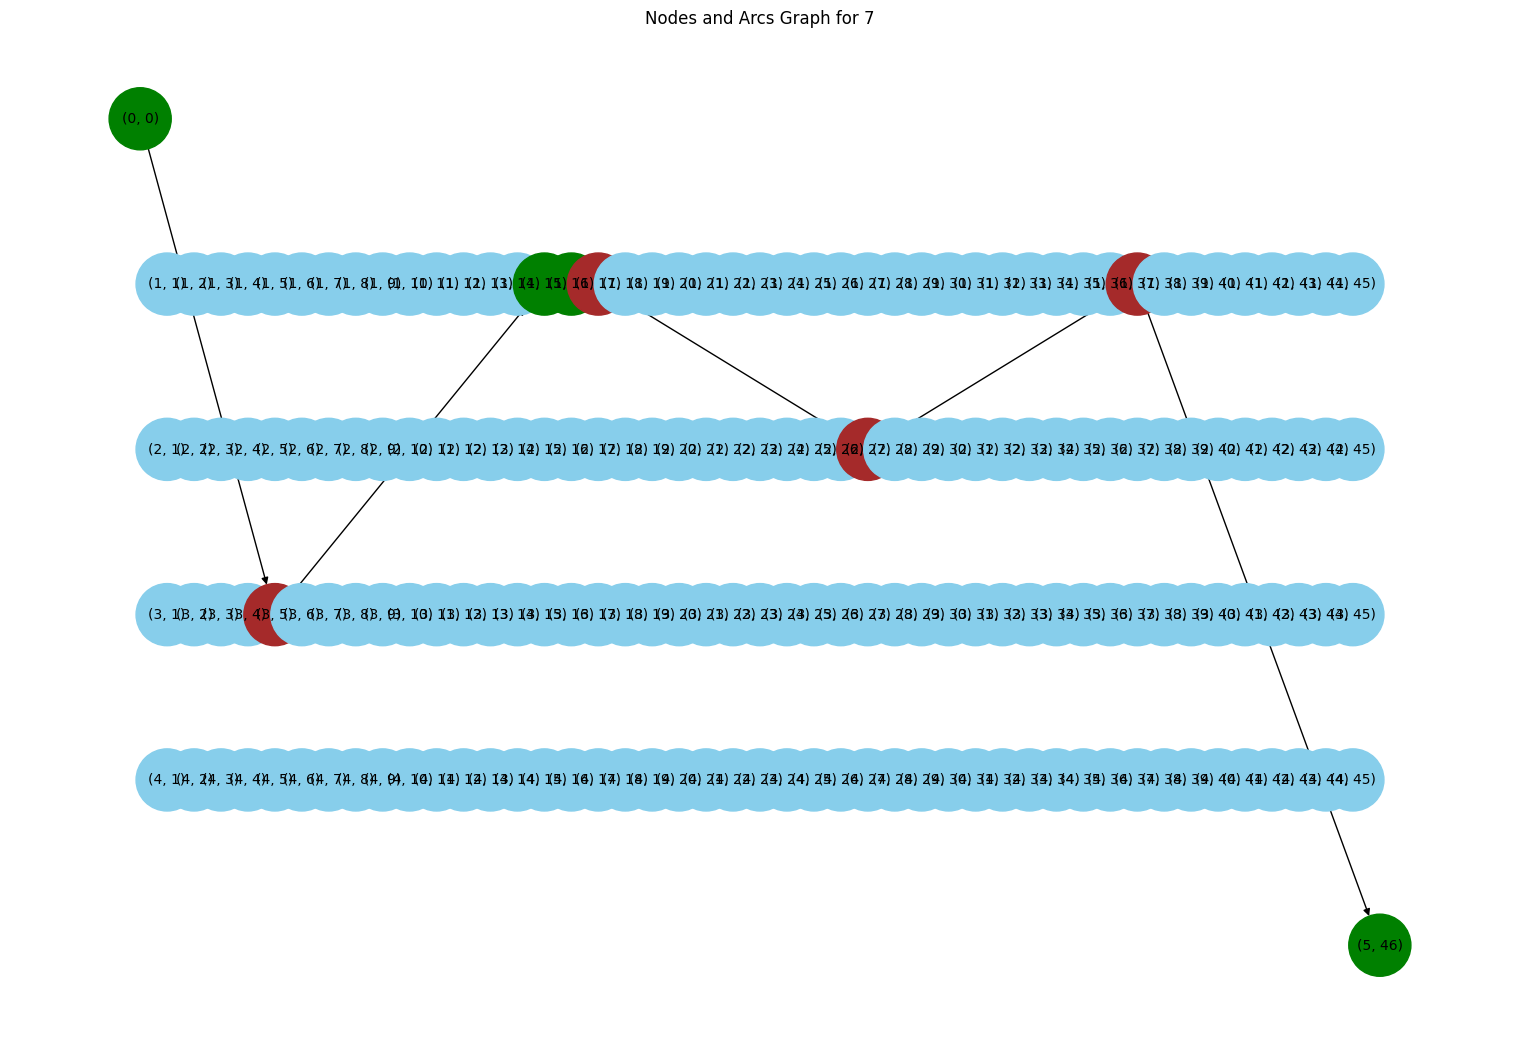

In [26]:
for i in range(1,len(vessels)+1):
    visualize_solution_for_vessel(i, vessel_arcs_dict, nodes, o_vars_dict)

In [27]:
vessel_arcs_dict

{1: [(0, 0) -> (4, 7) --- Cost: 0 --- Speed: 0,
  (4, 7) -> (1, 17) --- Cost: 0 --- Speed: 0,
  (1, 17) -> (1, 18) --- Cost: 0 --- Speed: 0,
  (1, 18) -> (4, 28) --- Cost: 0 --- Speed: 0,
  (4, 28) -> (1, 38) --- Cost: 0 --- Speed: 0,
  (1, 38) -> (1, 39) --- Cost: 0 --- Speed: 0,
  (1, 39) -> (5, 46) --- Cost: 0 --- Speed: 0],
 2: [(0, 0) -> (1, 8) --- Cost: 0 --- Speed: 0,
  (1, 8) -> (1, 9) --- Cost: 0 --- Speed: 0,
  (1, 9) -> (2, 19) --- Cost: 0 --- Speed: 0,
  (2, 19) -> (2, 20) --- Cost: 0 --- Speed: 0,
  (2, 20) -> (1, 30) --- Cost: 0 --- Speed: 0,
  (1, 30) -> (5, 46) --- Cost: 0 --- Speed: 0],
 3: [(0, 0) -> (1, 1) --- Cost: 0 --- Speed: 0,
  (1, 1) -> (1, 2) --- Cost: 0 --- Speed: 0,
  (1, 2) -> (1, 3) --- Cost: 0 --- Speed: 0,
  (1, 3) -> (1, 4) --- Cost: 0 --- Speed: 0,
  (1, 4) -> (1, 5) --- Cost: 0 --- Speed: 0,
  (1, 5) -> (4, 15) --- Cost: 0 --- Speed: 0,
  (4, 15) -> (4, 16) --- Cost: 0 --- Speed: 0,
  (4, 16) -> (4, 17) --- Cost: 0 --- Speed: 0,
  (4, 17) -> (4, 18) 

In [28]:
# Find amount of waiting arcs
non_util_dict = {}
for i in range(1,len(vessels)+1):
    sum = 0
    for arc in vessel_arcs_dict[i]:
        if arc.origin_node.port.number == arc.destination_node.port.number:
            sum += 1
    non_util_dict[i] = sum

In [29]:
# Find the time when the vessel traveled to the sink node
time_sink_dict = {}
for i in range(1,len(vessels)+1):
    for arc in vessel_arcs_dict[i]:
        if arc.destination_node.port.number == len(ports)+1:
            travel_time_sink = arc.origin_node.time
            time_sink_dict[i] = TIME_PERIODS - travel_time_sink 
            break

In [30]:
time_sink_dict

{1: 6, 2: 15, 3: 7, 4: 8, 5: 11, 6: 12, 7: 8}

In [31]:
non_util_dict

{1: 2, 2: 2, 3: 7, 4: 0, 5: 0, 6: 1, 7: 2}

In [32]:
# For each vessel, save the route, but only the port-sequence
vessel_routes_seq = {}
for i in range(1, len(vessels)+1):
    vessel_routes_seq[i] = []
    for arc in vessel_arcs_dict[i]:
        vessel_routes_seq[i].append(arc.destination_node.port.number)
        
vessel_routes_seq

{1: [4, 1, 1, 4, 1, 1, 5],
 2: [1, 1, 2, 2, 1, 5],
 3: [1, 1, 1, 1, 1, 4, 4, 4, 4, 1, 2, 5],
 4: [1, 3, 1, 4, 3, 5],
 5: [1, 2, 1, 3, 2, 5],
 6: [2, 2, 1, 3, 1, 5],
 7: [3, 1, 1, 1, 2, 1, 5]}

In [33]:
from collections import Counter

most_frequent_counts = {}

for key, values in vessel_routes_seq.items():
    counter = Counter(values)
    most_common = counter.most_common(1)[0]  # Returns a list of the most common element and its count
    most_frequent_counts[key] = most_common[1]  # Store the count of the most common element

most_frequent_counts

{1: 4, 2: 3, 3: 6, 4: 2, 5: 2, 6: 2, 7: 4}

In [21]:
MAX_VISITS_FOR_VESSEL = {v: time_sink_dict[v] + non_util_dict[v] + most_frequent_counts[v] for v in range(1, len(vessels) + 1)}
MAX_VISITS_FOR_VESSEL

{1: 12, 2: 20, 3: 20, 4: 10, 5: 13, 6: 15, 7: 14}

In [22]:
# Remove numbers that are after each other and that are the same
for i in range(1, len(vessels)+1):
    vessel_routes_seq[i] = [x for x, y in zip(vessel_routes_seq[i], vessel_routes_seq[i][1:]) if x != y]
    
vessel_routes_seq

{1: [4, 1, 4, 1],
 2: [1, 2, 1],
 3: [1, 4, 1, 2],
 4: [1, 3, 1, 4, 3],
 5: [1, 2, 1, 3, 2],
 6: [2, 1],
 7: [3, 1, 2, 1]}